<a href="https://colab.research.google.com/github/LironOhana/badnets-backdoor-attacks-ml/blob/main/BadNets_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BadNets – Experimental Analysis

This notebook presents the experimental results of my final project on backdoor attacks
in deep learning, based on the BadNets framework.

All experiments are executed once and saved with outputs.
No re-running is required to view the results.


> **Note:** Full discussion, conclusions, and figures are documented in the project **README**.
> This notebook is provided as an executed, step-by-step run log that reproduces the results,
> so the outputs can be viewed directly without re-running the code.


## Experimental Setting and Evaluation Metrics

This project is based on the original **BadNets** backdoor attack as introduced by
Gu et al. (2017), and on an open-source reference implementation.

Beyond reproducing the original baseline experiment, an extended experimental
infrastructure was designed and implemented as part of this work. This infrastructure
enables systematic evaluation of the attack under variations of key parameters.

- Dataset: MNIST (28×28 grayscale images)
- Model: Convolutional Neural Network (CNN)
- Attack: BadNets backdoor attack

**Evaluation metrics:**
- **TCA (Test Clean Accuracy):** accuracy on clean test data
- **ASR (Attack Success Rate):** success rate of the attack when the trigger is present


## Setup


In [41]:
# Setup (Colab): fresh clone to avoid stale code
%cd /content
!rm -rf badnets-backdoor-attacks-ml
!git clone https://github.com/LironOhana/badnets-backdoor-attacks-ml.git
%cd badnets-backdoor-attacks-ml
!pip install -r requirements.txt


/content
Cloning into 'badnets-backdoor-attacks-ml'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 75 (delta 32), reused 26 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 67.50 KiB | 4.22 MiB/s, done.
Resolving deltas: 100% (32/32), done.
/content/badnets-backdoor-attacks-ml


In [42]:
from pathlib import Path
from IPython.display import Image, display


## Experiment 1 – Basic Experiment (Baseline)

This experiment reproduces the baseline BadNets configuration as a sanity check.


In [43]:
!python experiments/exp01_baseline.py --device cuda

[exp01] running main.py with poisoning_rate=0.1, epochs=100, device=cuda
Namespace(dataset='MNIST',
nb_classes=10,
load_local=False,
loss='mse',
optimizer='sgd',
epochs=100,
batch_size=64,
num_workers=4,
lr=0.01,
download=False,
data_path='./data/',
device='cuda',
seed=0,
poisoning_rate=0.1,
trigger_label=1,
trigger_path='./triggers/trigger_white.png',
trigger_size=5,
trigger_pos='br',
run_name='default')

# Seed fixed to: 0

# Using device: cuda

# load dataset: MNIST 
Transform =  Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
100% 9.91M/9.91M [00:00<00:00, 14.3MB/s]
100% 28.9k/28.9k [00:00<00:00, 340kB/s]
100% 1.65M/1.65M [00:00<00:00, 3.16MB/s]
100% 4.54k/4.54k [00:00<00:00, 24.9MB/s]
Poison 6000 over 60000 samples ( poisoning rate 0.1)
Number of the class = 10
Dataset MNISTPoison
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=

## Experiment 2 – Impact of Poisoning Rate in Data

Goal: Test how the poisoning rate affects ASR (attack success rate) and TCA (clean accuracy),
and identify a minimum threshold where the backdoor transitions from failure to success.


### Run: Poisoning rate sweep (training + CSV export)


In [34]:
!python experiments/exp02_run_all_poisoning_rates.py --device cuda

Streaming output truncated to the last 5000 lines.
# Using device: cuda

# load dataset: MNIST 
Transform =  Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
Poison 1800 over 60000 samples ( poisoning rate 0.03)
Number of the class = 10
Dataset MNISTPoison
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Transform =  Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
Poison 10000 over 10000 samples ( poisoning rate 1.0)
Number of the class = 10
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           ) Dataset MNISTPoison
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(
      

### Analyze: Generate figures from the CSV results


In [35]:
!python analysis/plot_exp02_poisoning_rate.py

[exp02] poisoning_rate values found: [0.01, 0.02, 0.025, 0.0275, 0.03, 0.05]
Saved summary table: /content/badnets-backdoor-attacks-ml/results/figures/exp02_summary_poisoning_rate.csv
 poisoning_rate    asr    tca  n_runs
         0.0100 0.1154 0.9826       1
         0.0200 0.1177 0.9830       1
         0.0250 0.9519 0.9805       1
         0.0275 0.9954 0.9834       1
         0.0300 0.9965 0.9825       1
         0.0500 0.9989 0.9815       1
Saved: /content/badnets-backdoor-attacks-ml/results/figures/exp02_asr_vs_poisoning_rate.png
Saved: /content/badnets-backdoor-attacks-ml/results/figures/exp02_tca_vs_poisoning_rate.png
Saved: /content/badnets-backdoor-attacks-ml/results/figures/exp02_asr_vs_epoch_selected.png


### Display: Figures (saved under `results/figures/`)


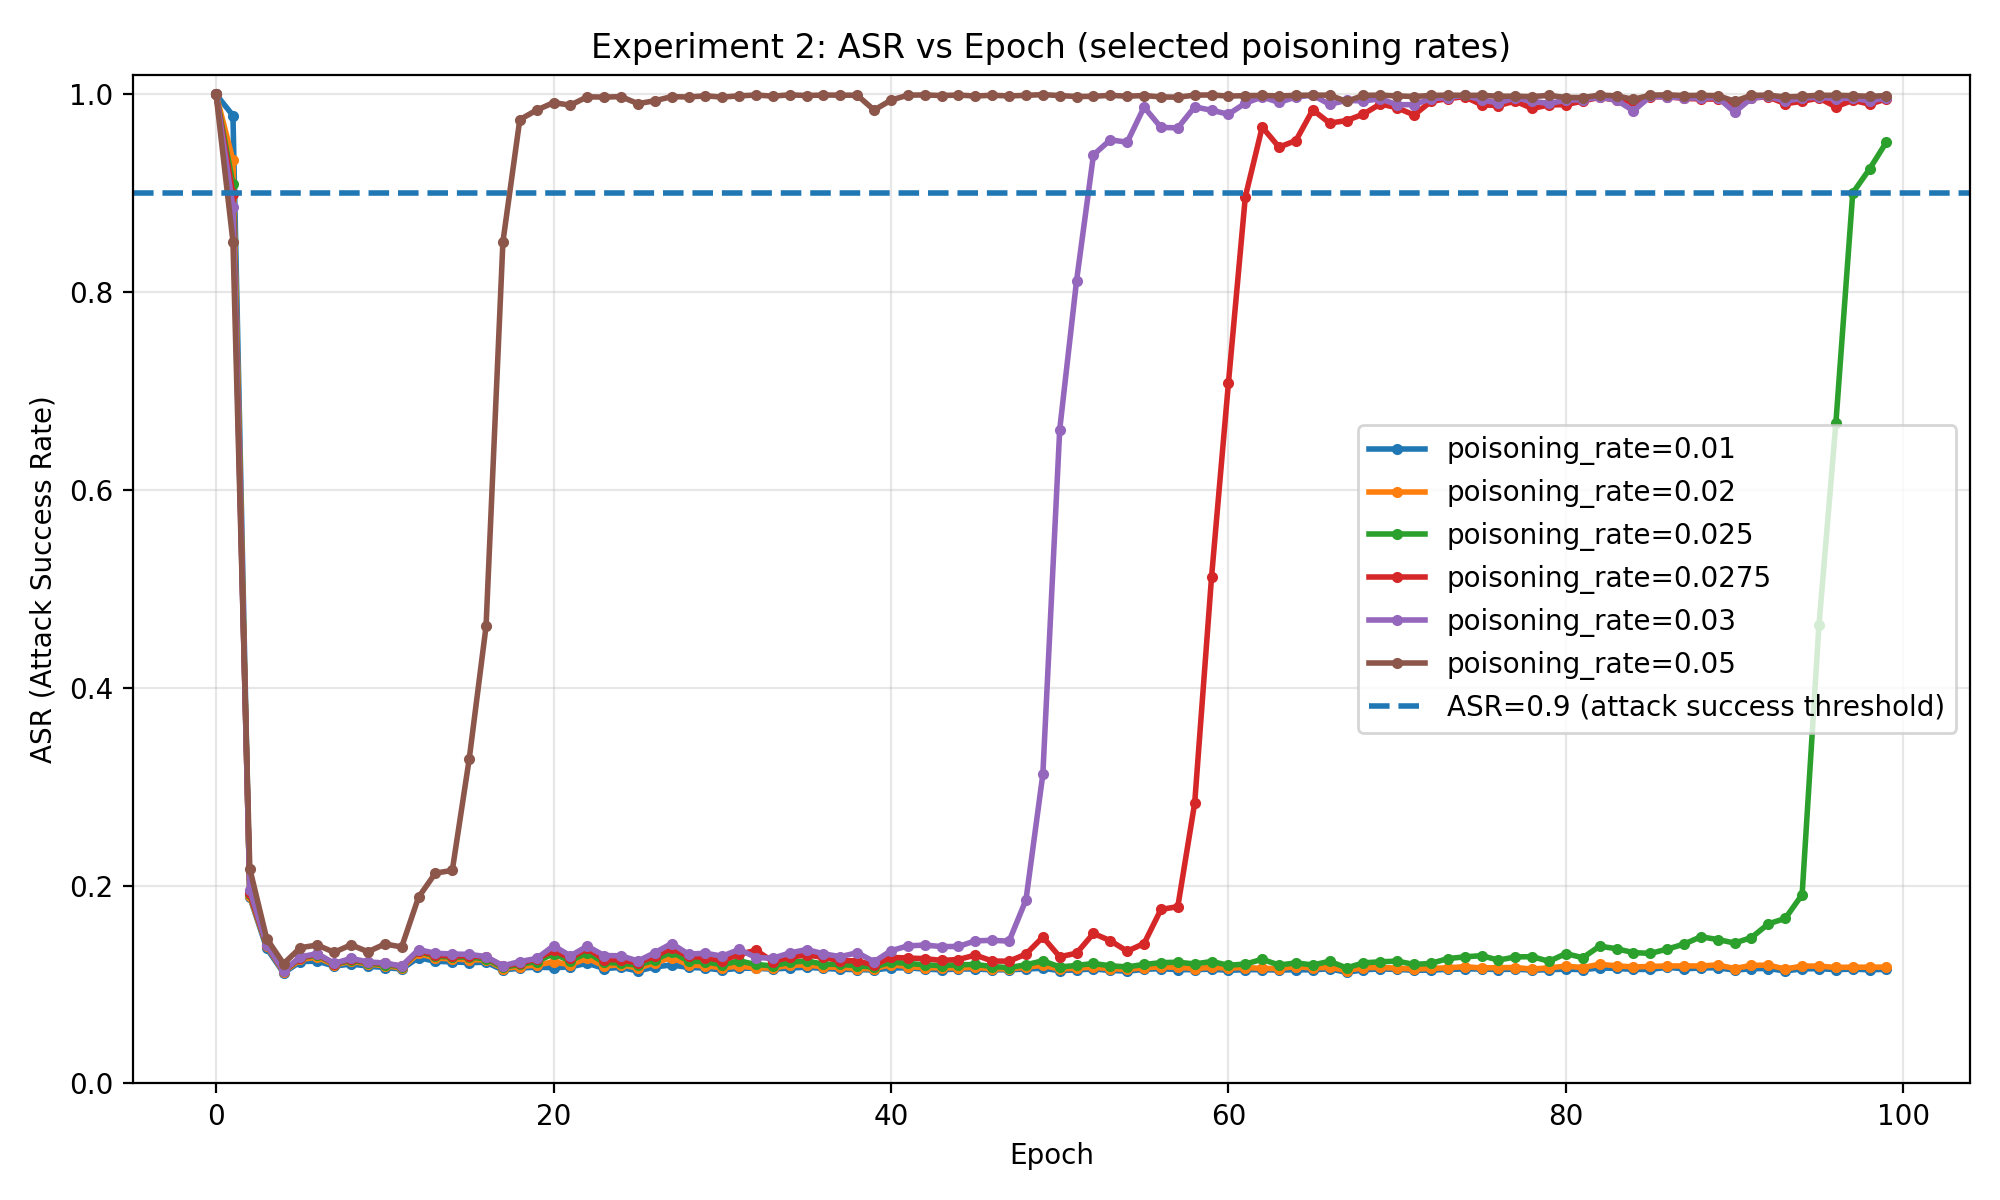

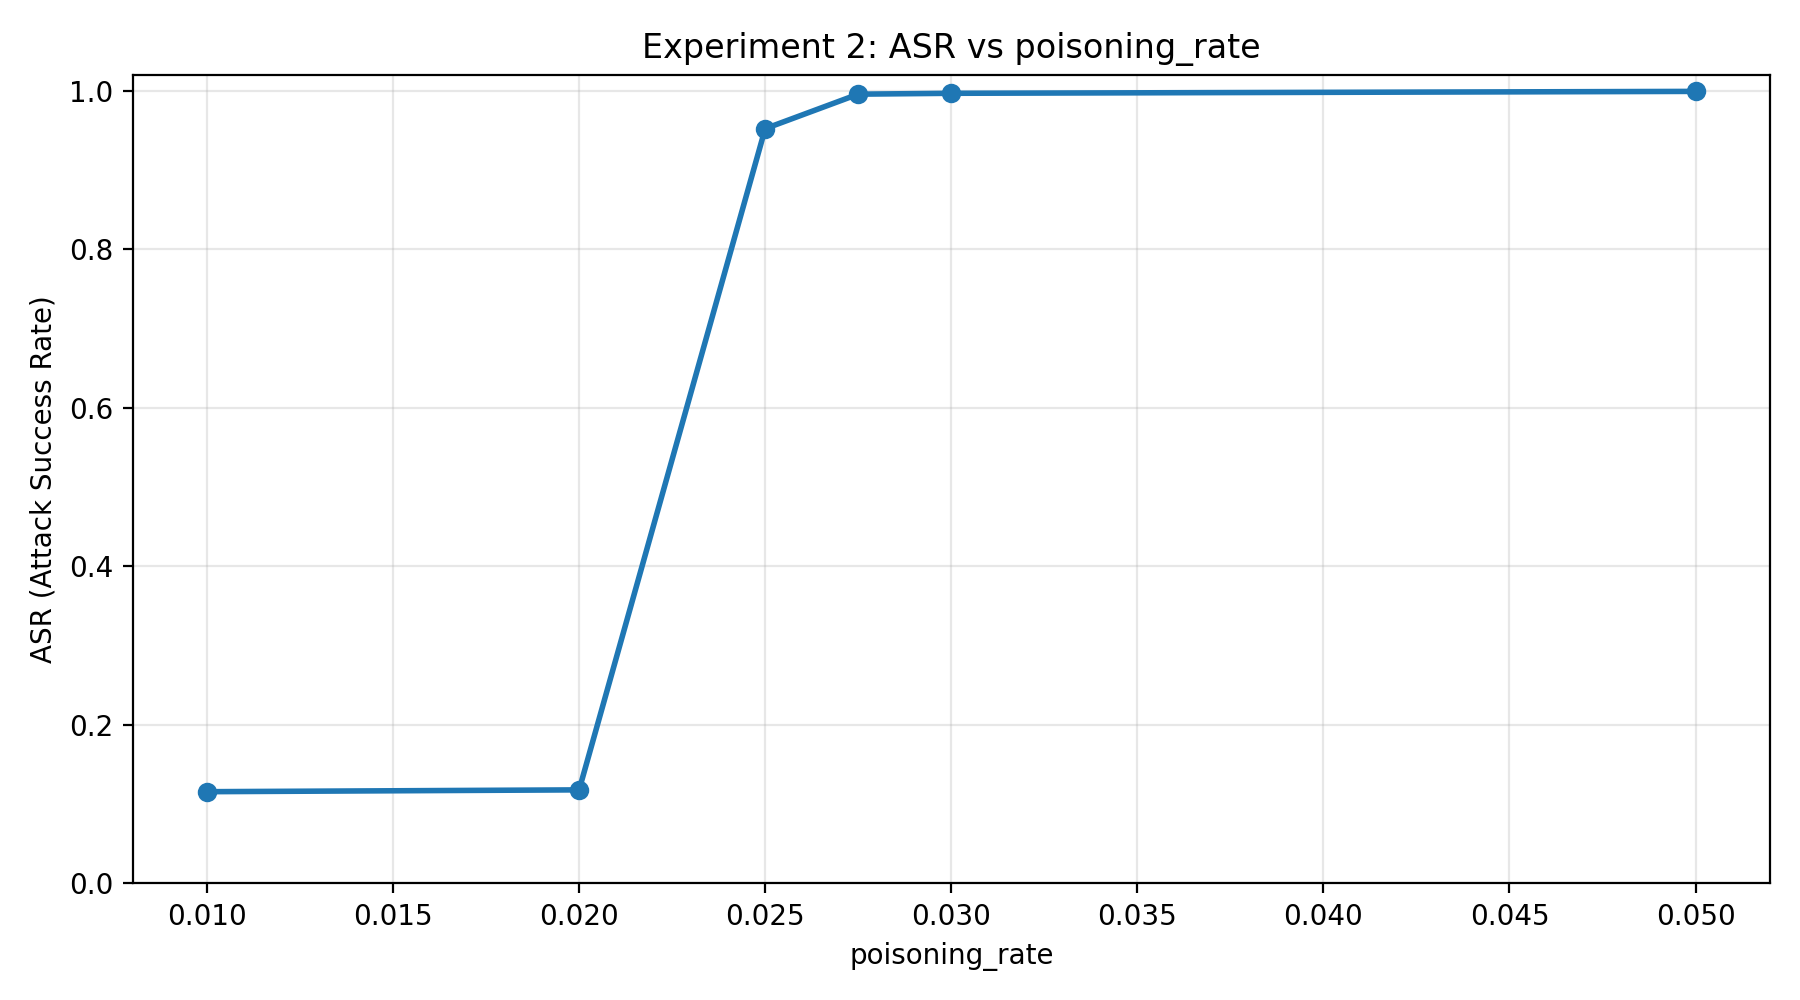

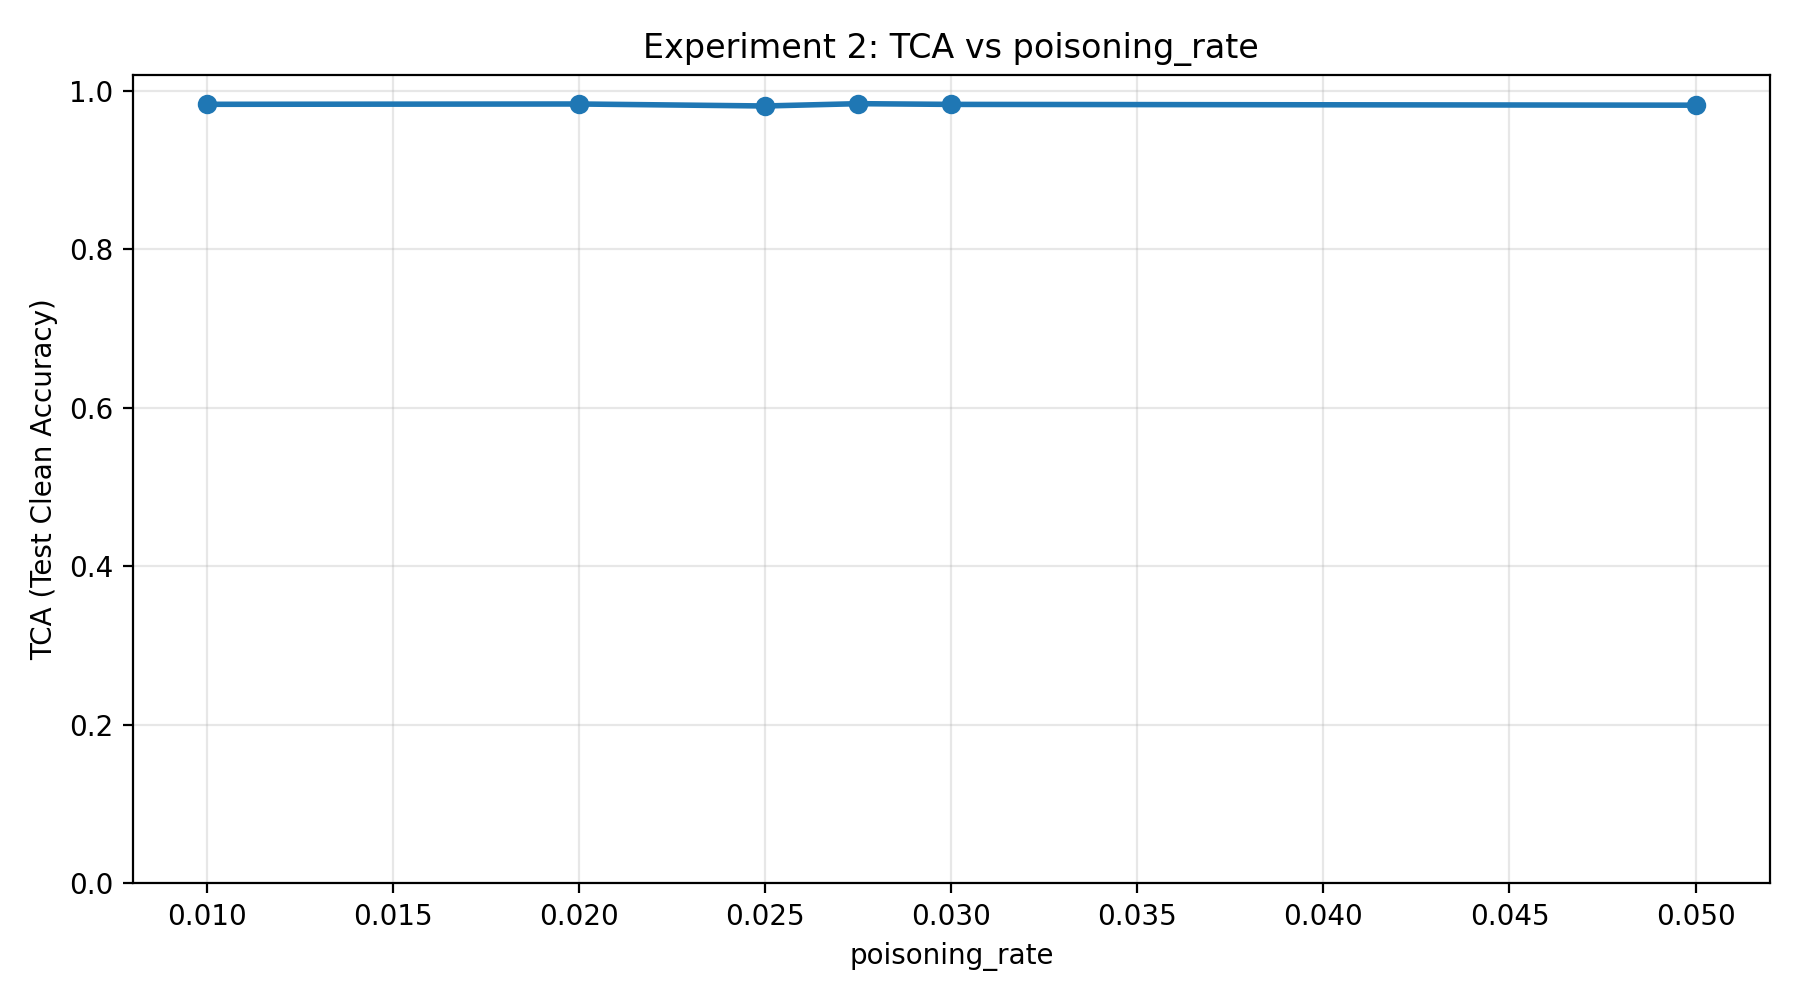

In [36]:
fig_dir = Path("results/figures")
for p in sorted(fig_dir.glob("exp02_*.png")):
    display(Image(filename=str(p)))

## Experiment 3 – Impact of Trigger Size

Goal: Test whether there is a minimum trigger size required for successful backdoor embedding,
and measure the effect of trigger size on ASR and TCA.


### Run: Trigger size sweep (training + CSV export)

In [44]:
!python experiments/exp03_run_all_trigger_sizes.py --device cuda

Streaming output truncated to the last 5000 lines.
trigger_label=1,
trigger_path='./triggers/trigger_white.png',
trigger_size=4,
trigger_pos='br',
run_name='exp03_ts4')

# Seed fixed to: 0

# Using device: cuda

# load dataset: MNIST 
Transform =  Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
Poison 3000 over 60000 samples ( poisoning rate 0.05)
Number of the class = 10
Dataset MNISTPoison
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Transform =  Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)
Poison 10000 over 10000 samples ( poisoning rate 1.0)
Number of the class = 10
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           ) Data

### Analyze: Generate figures from the CSV results

In [45]:
!python analysis/plot_exp03_trigger_size.py

[exp03] trigger_size values found: [1, 3, 4, 5]
Saved summary table: /content/badnets-backdoor-attacks-ml/results/figures/exp03_summary_trigger_size.csv
 trigger_size    asr    tca  n_runs
            1 0.1143 0.9811       1
            3 0.1142 0.9812       1
            4 0.1163 0.9819       1
            5 0.9989 0.9815       1
Saved: /content/badnets-backdoor-attacks-ml/results/figures/exp03_asr_vs_trigger_size.png
Saved: /content/badnets-backdoor-attacks-ml/results/figures/exp03_tca_vs_trigger_size.png
[exp03] rows for trigger_size=4: 100
[exp03] rows for trigger_size=5: 100
Saved: /content/badnets-backdoor-attacks-ml/results/figures/exp03_asr_vs_epoch.png


### Display: Figures (saved under `results/figures/`)

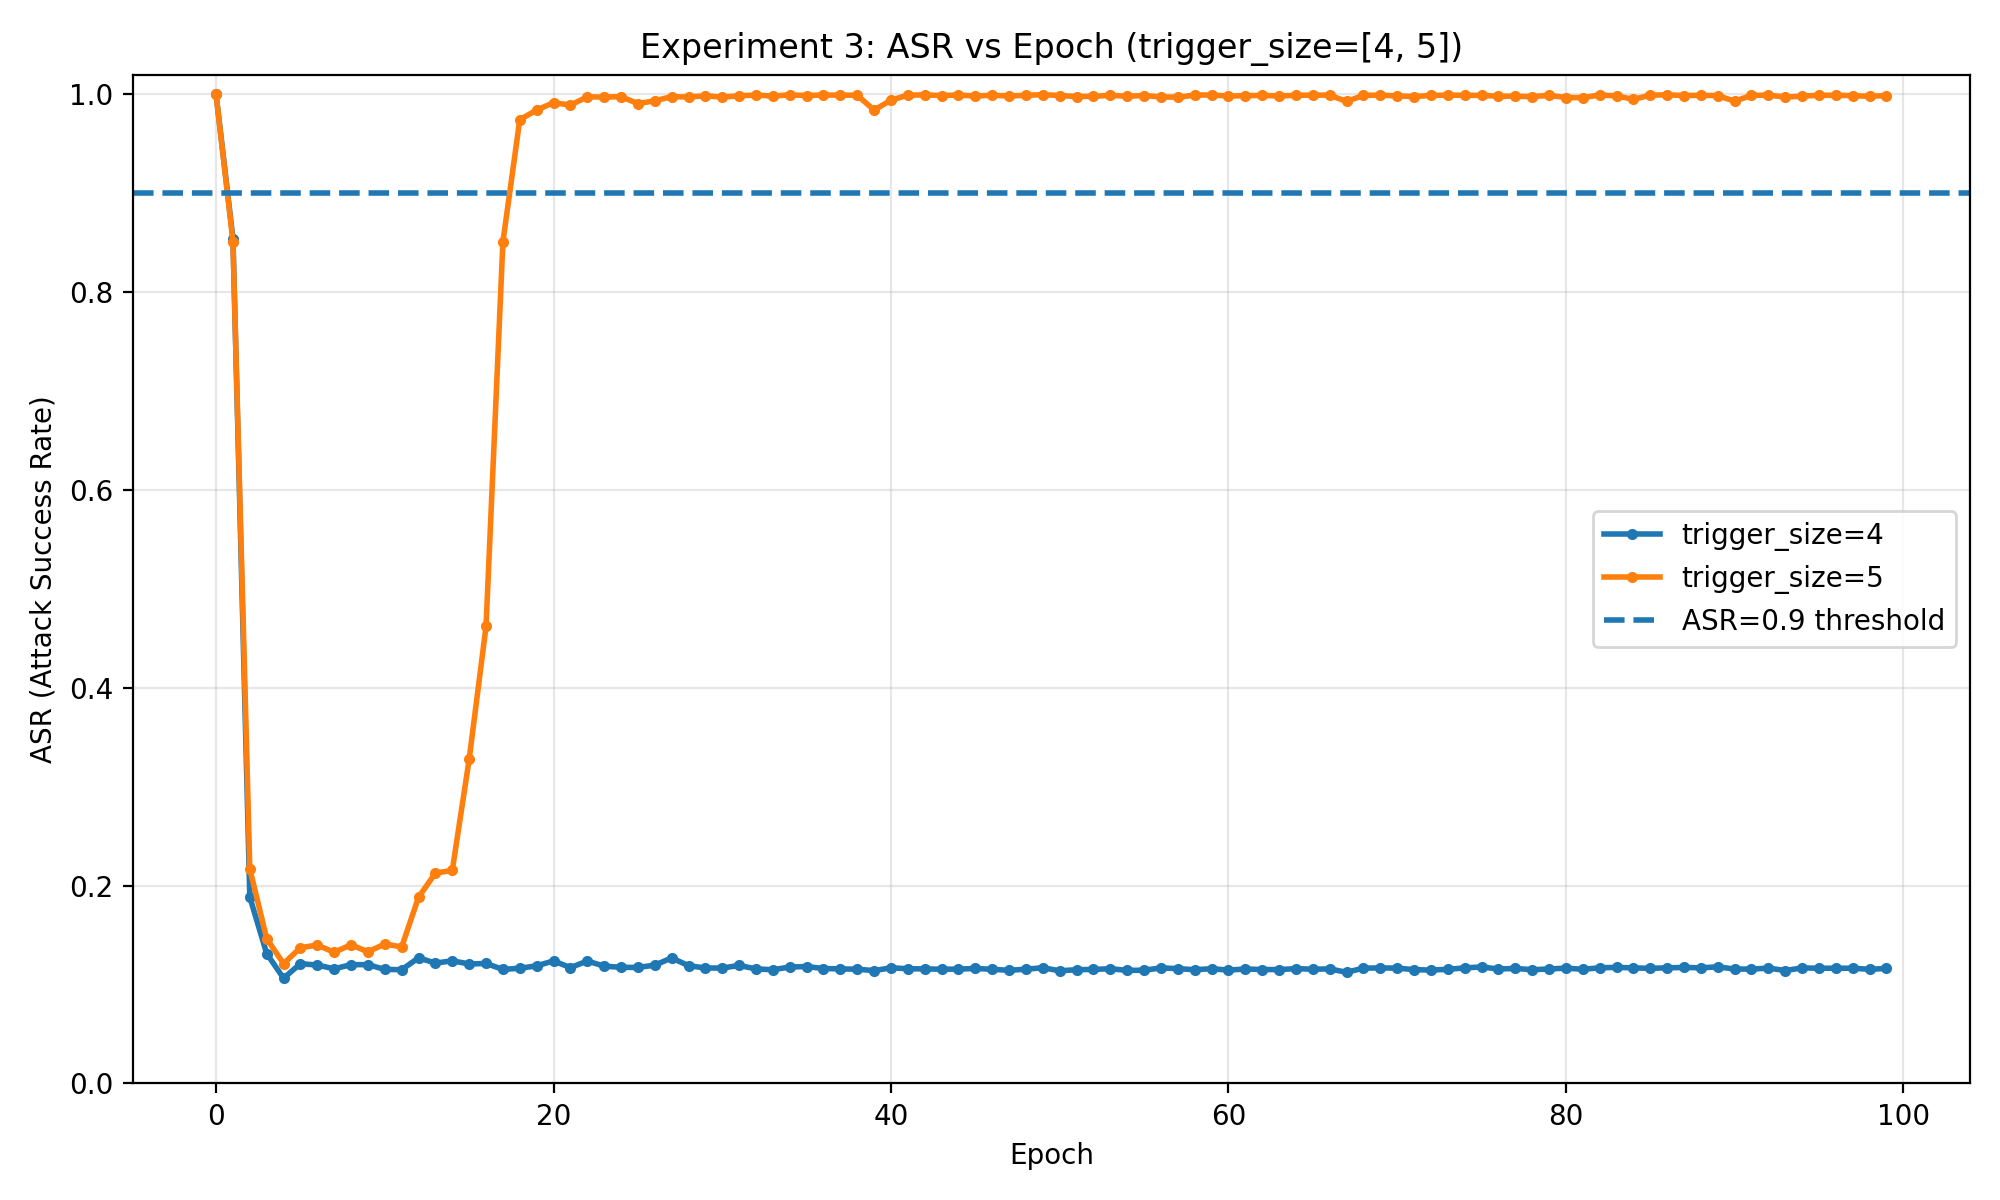

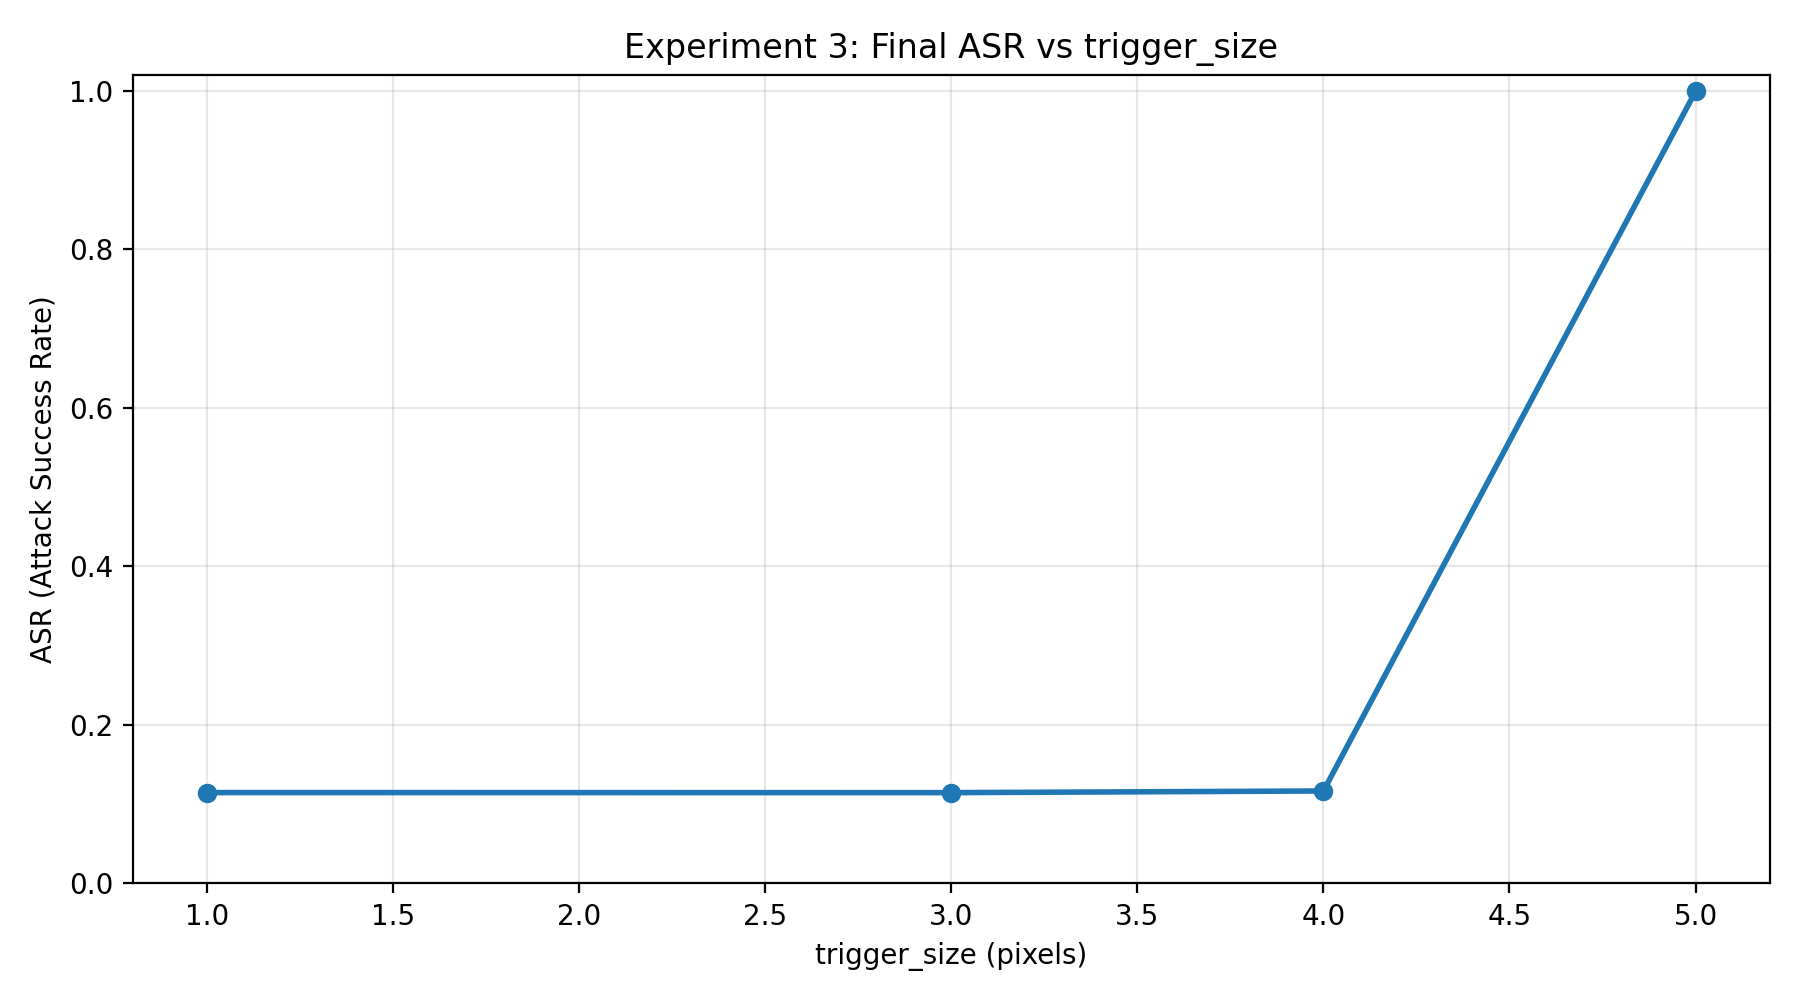

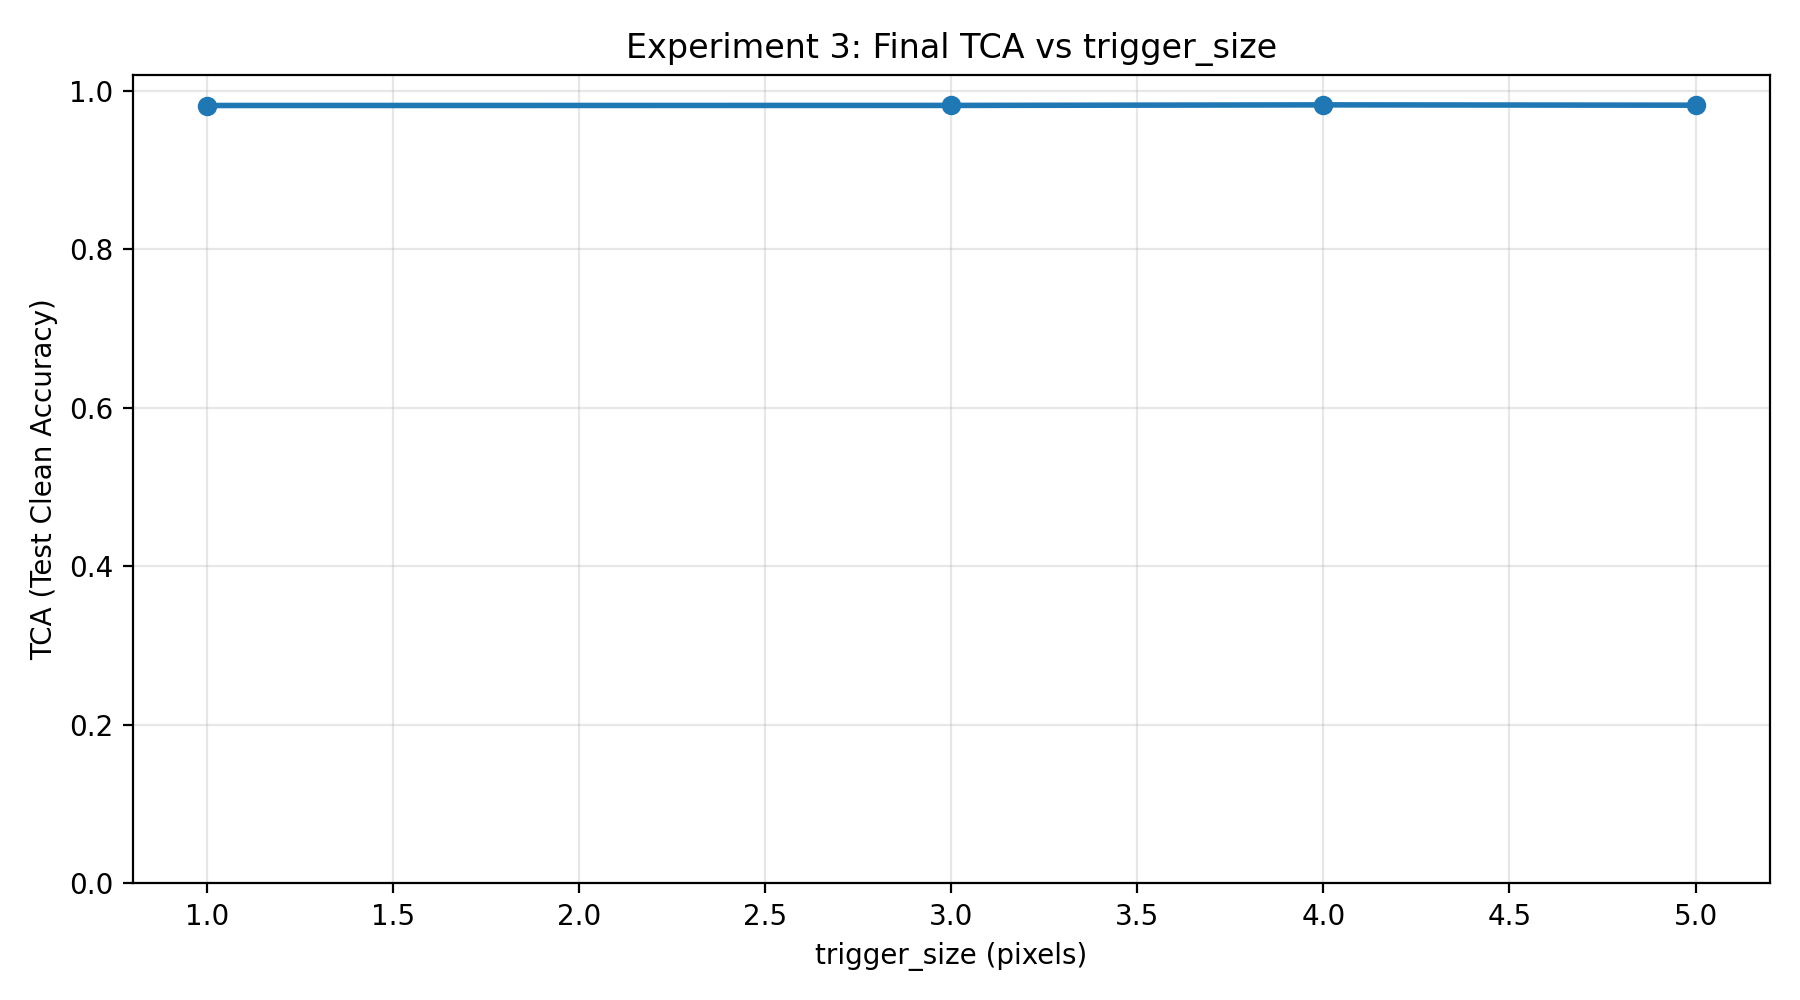

In [46]:
fig_dir = Path("results/figures")
for p in sorted(fig_dir.glob("exp03_*.png")):
    display(Image(filename=str(p)))

## Experiment 4 – Impact of Trigger Position

Goal: Test how the trigger position affects the learning dynamics of the backdoor,
and compare ASR and TCA across different fixed locations.


### Run: Trigger position sweep (training + CSV export)

In [47]:
!python experiments/exp04_run_all_positions.py --device cuda

Streaming output truncated to the last 5000 lines.
   3 - three       0.98      0.98      0.98      1010
    4 - four       0.97      0.99      0.98       982
    5 - five       0.98      0.97      0.98       892
     6 - six       0.99      0.98      0.98       958
   7 - seven       0.98      0.98      0.98      1028
   8 - eight       0.98      0.97      0.98       974
    9 - nine       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

100% 157/157 [00:01<00:00, 143.23it/s]
# EPOCH 97   loss: 1.4727 Test Acc: 0.9818, ASR: 0.9993

100% 938/938 [00:05<00:00, 179.10it/s]
100% 157/157 [00:00<00:00, 216.35it/s]
              precision    recall  f1-score   support

    0 - zero       0.98      0.99      0.99       980
     1 - one       0.99      0.99      0.99      1135
     2 - two       0.98      0.98      0.98      1032
   3 - three    

### Analyze: Generate figures from the CSV results

In [48]:
!python analysis/plot_exp04_trigger_pos.py

Saved: /content/badnets-backdoor-attacks-ml/results/figures/exp04_asr_vs_epoch_all_positions.png
Saved summary table: /content/badnets-backdoor-attacks-ml/results/figures/exp04_summary.csv
  trigger_pos  final_asr  final_tca  n_runs
3          tl     0.9992     0.9831       1
4          tr     0.9987     0.9817       1
0          bl     0.9981     0.9823       1
1          br     0.9989     0.9815       1
2      center     0.9800     0.9786       1
Saved: /content/badnets-backdoor-attacks-ml/results/figures/exp04_final_asr_by_position.png
Saved: /content/badnets-backdoor-attacks-ml/results/figures/exp04_final_tca_by_position.png


### Display: Figures (saved under `results/figures/`)

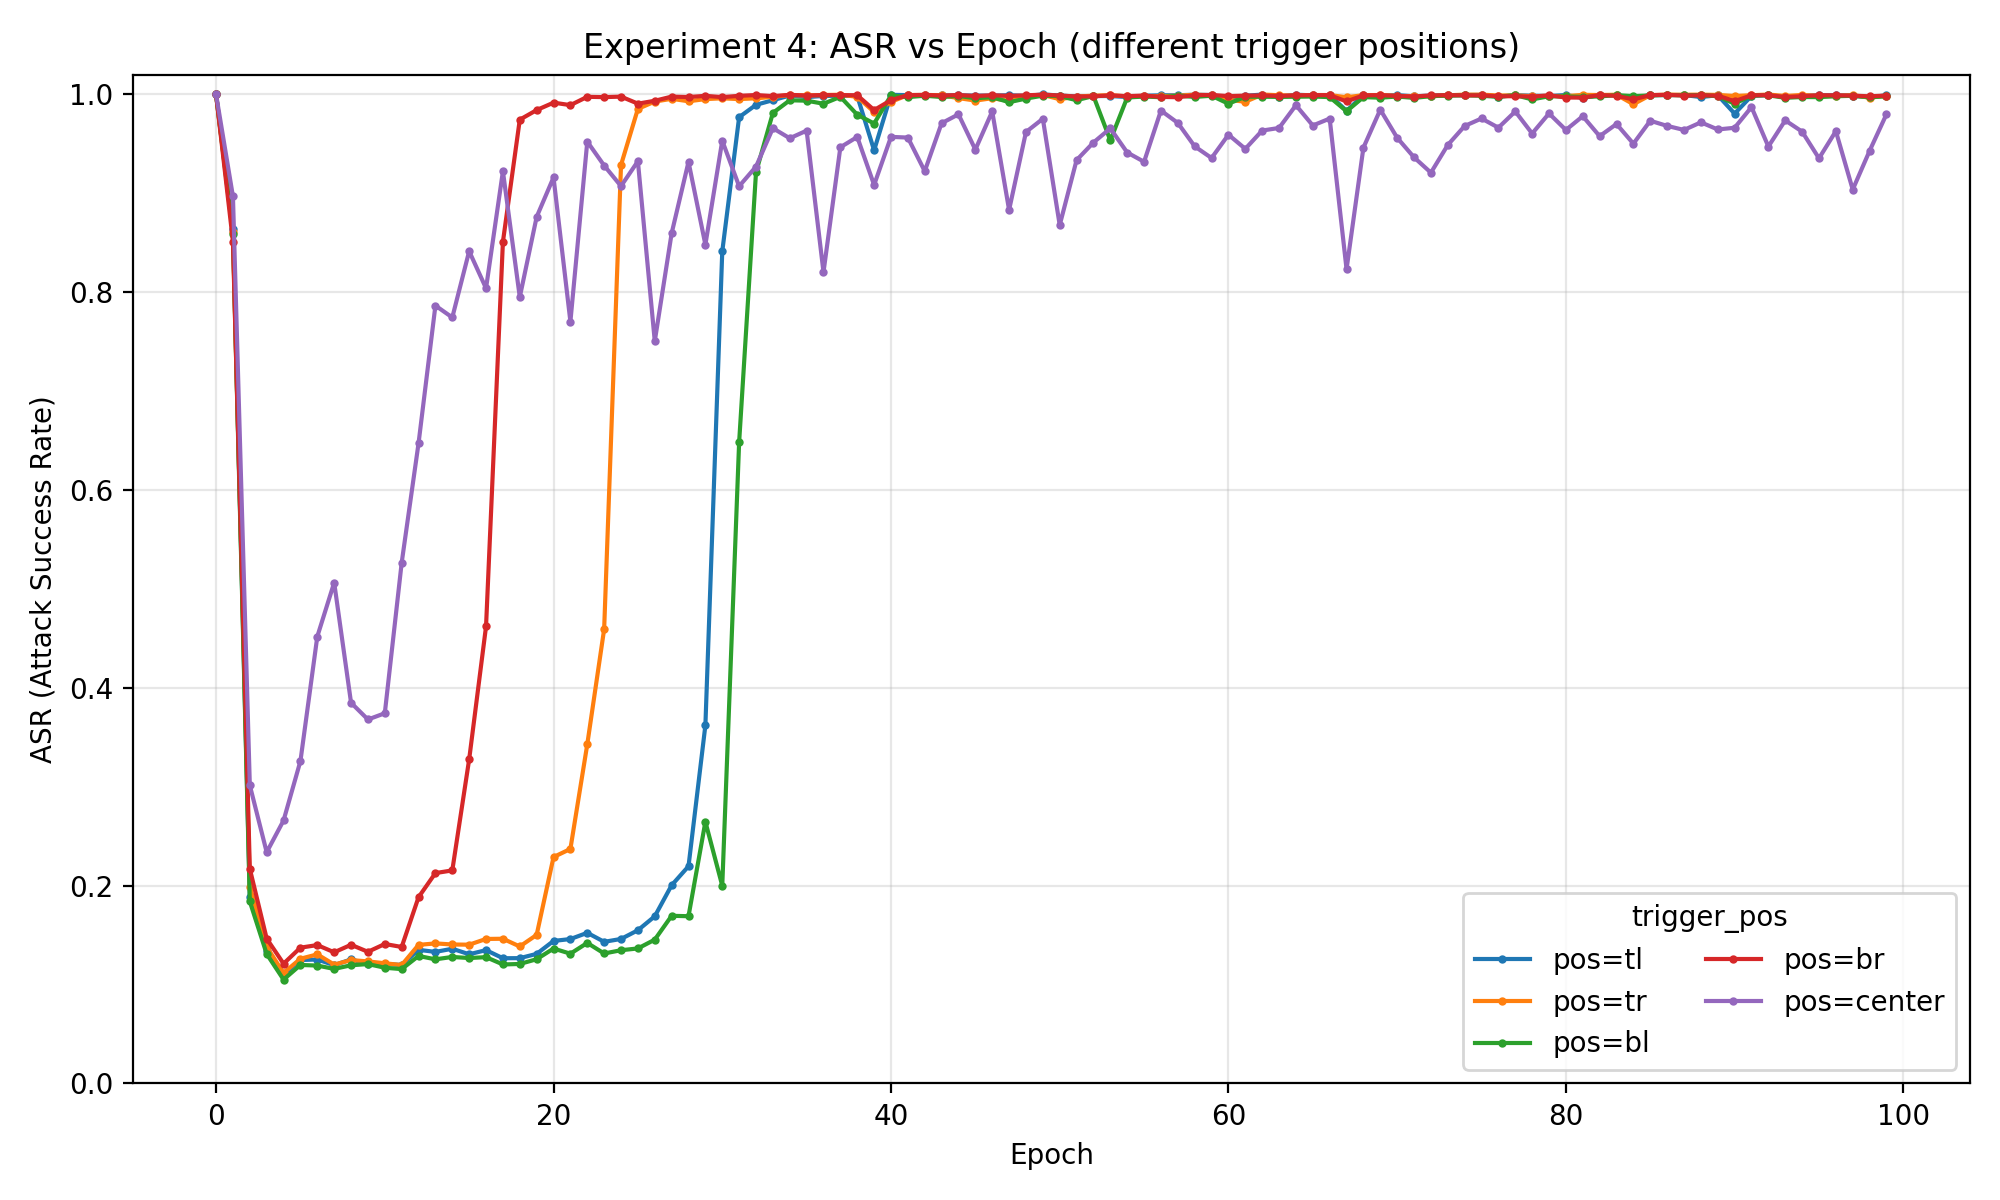

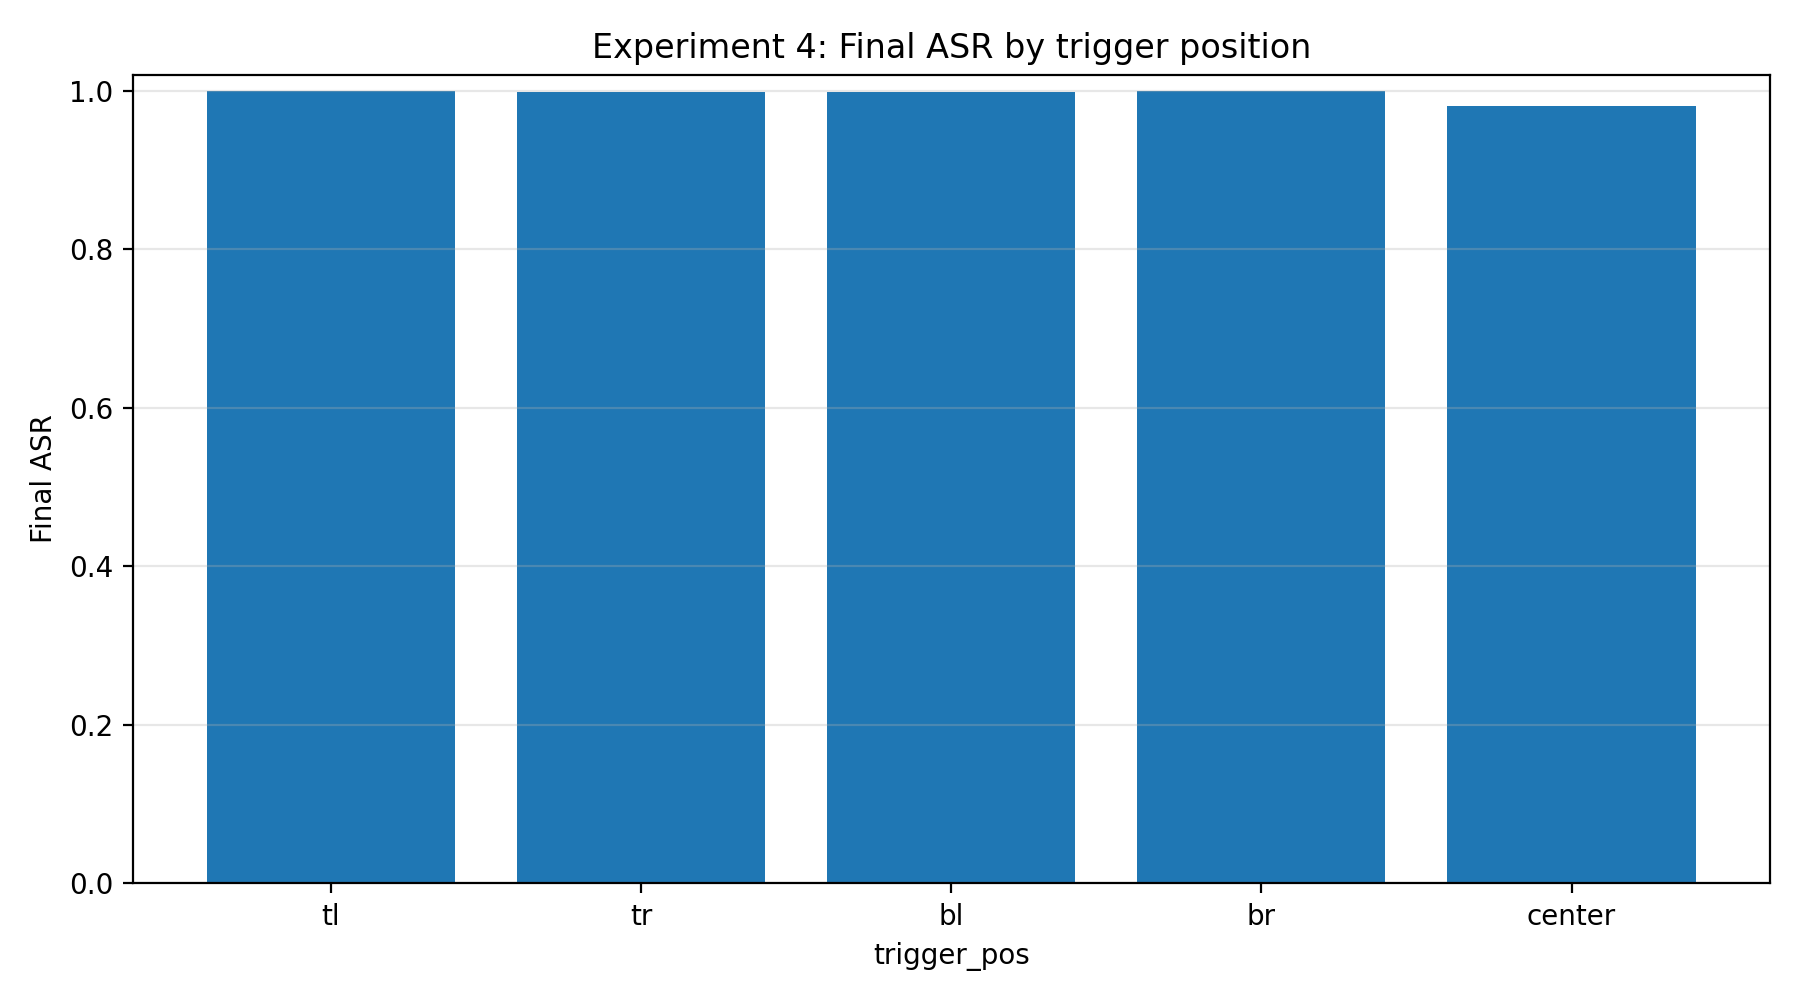

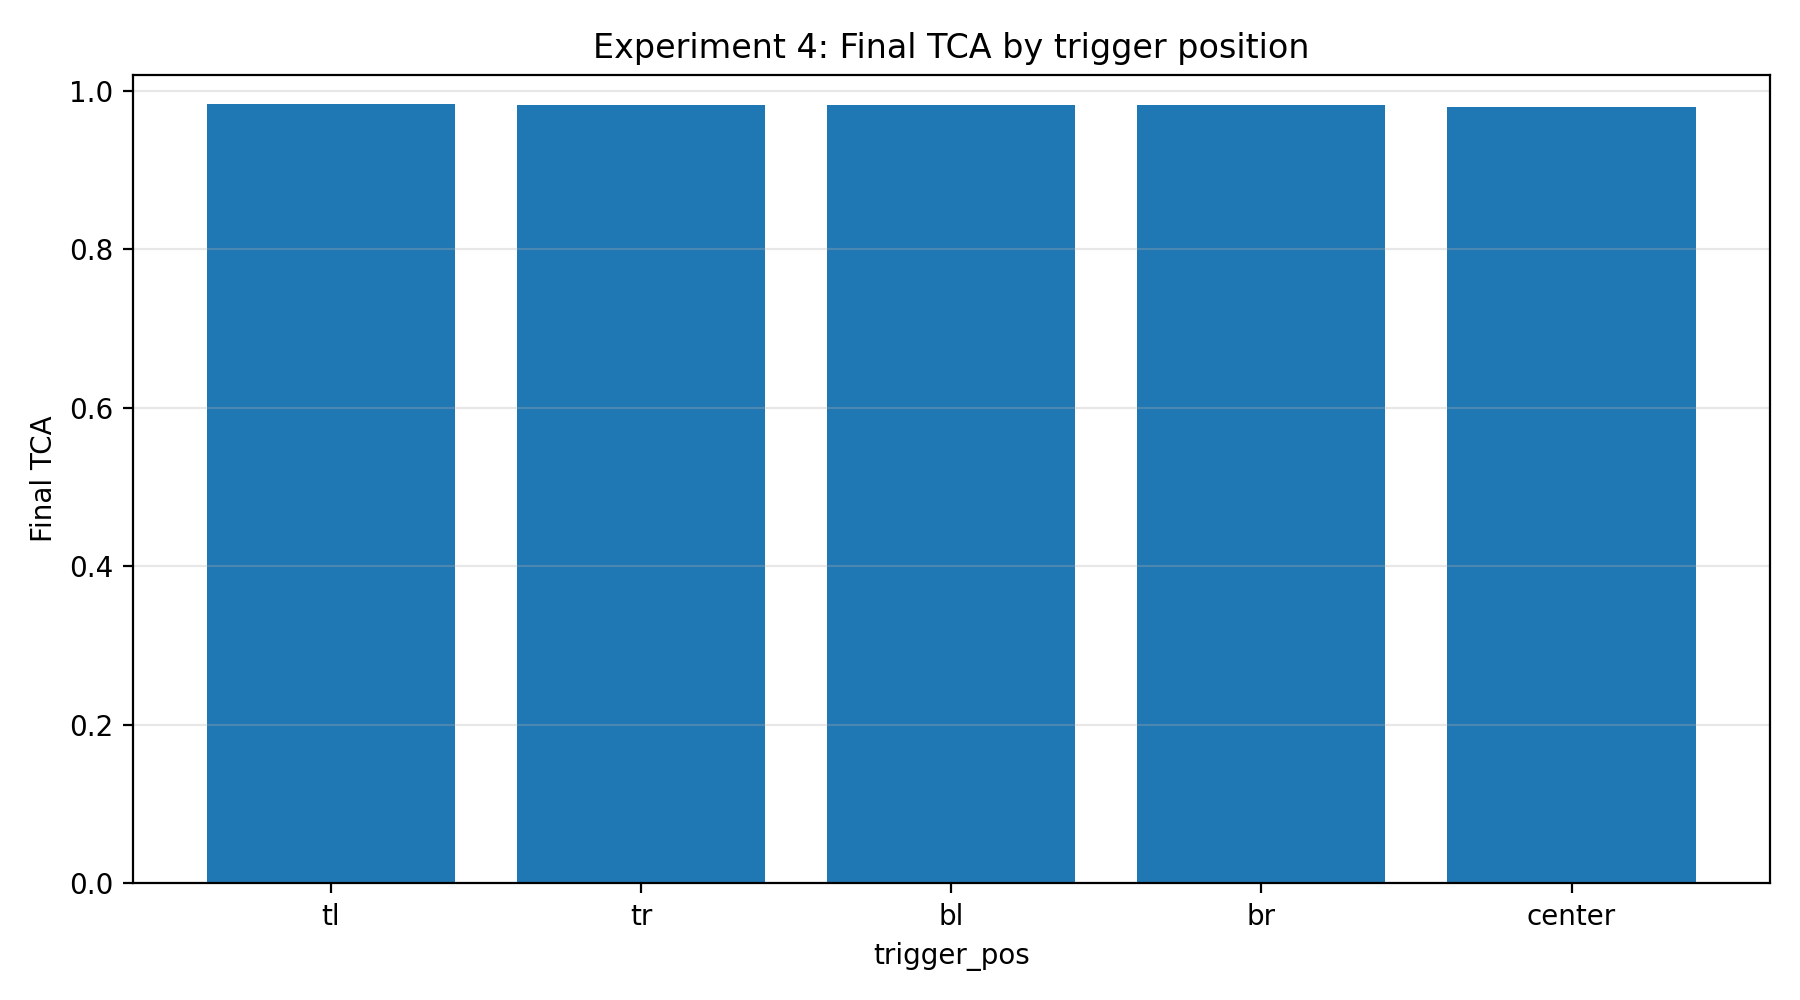

In [49]:
fig_dir = Path("results/figures")
for p in sorted(fig_dir.glob("exp04_*.png")):
    display(Image(filename=str(p)))

## Summary

- The notebook reproduces the **baseline BadNets** experiment and then runs three additional experiments
  implemented as part of this project: **poisoning rate**, **trigger size**, and **trigger position**.
- Across experiments, the results show that a model can maintain **high clean accuracy (TCA)** while
  still containing an effective backdoor with **high attack success rate (ASR)**.
- The experiments highlight clear **threshold effects** (e.g., poisoning rate / trigger size) and
  show that **visual characteristics** (trigger position) can affect learning dynamics.

For the full written analysis and conclusions, refer to the **README** in the repository.